## 1. Setting Up the Environment

Before we dive into building our agent, we need to set up the necessary environment. This involves installing required packages and ensuring our Python environment is ready for development.

In [237]:
# Install termcolor for colored terminal outputs
%pip install termcolor langgraph

Note: you may need to restart the kernel to use updated packages.


In [238]:
# Import necessary libraries
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from datetime import datetime, timezone
from termcolor import colored
import time

In [239]:
# Get the current date and time in UTC
def get_current_utc_datetime():
    now_utc = datetime.now(timezone.utc)
    return now_utc.strftime("%Y-%m-%d %H:%M:%S.%f UTC")[:-3]  # Truncate to milliseconds

In [240]:
# Define the state object for the agent graph
class AgentGraphState(TypedDict):
    start_chain: Annotated[list, add_messages]
    transcription_response: Annotated[list, add_messages]
    portuguese_response: Annotated[list, add_messages]
    spanish_response: Annotated[list, add_messages]
    end_chain: Annotated[list, add_messages]


# Function to retrieve specific parts of the agent state
def get_agent_graph_state(state: AgentGraphState, state_key: str):

    if state_key == "transcription_all":
        return state["transcription_response"]
    elif state_key == "transcription_latest":
        return (
            state["transcription_response"][-1]
            if state["transcription_response"]
            else []
        )

    if state_key == "portuguese_all":
        return state["portuguese_response"]
    elif state_key == "portuguese_latest":
        return state["portuguese_response"][-1] if state["portuguese_response"] else []

    if state_key == "spanish_all":
        return state["spanish_response"]
    elif state_key == "spanish_latest":
        return state["spanish_response"][-1] if state["spanish_response"] else []

    else:
        return None


# Initial state setup
state = {
    "start_chain": [],
    "transcription_response": [],
    "portuguese_response": [],
    "spanish_response": [],
    "end_chain": [],
}

In [241]:
import asyncio

class TranscriptAgent:

    def __init__(self, state: AgentGraphState, words: list):
        self.state = state
        self.words = words

    async def invoke(self):
        print(colored(f"TRANSCRIPT_AGENT 📝: START TRANSCRIPT", "cyan"))
        for word in self.words:
            await asyncio.sleep(1)  # Simulate async operation
            print(colored(f"TRANSCRIPT_AGENT 📝: Processing word '{word}'", "cyan"))
            self.state["transcription_response"].append(word)
            yield self.state

        print(colored(f"TRANSCRIPT_AGENT 📝: END CHAIN", "green"))
        self.state["end_chain"].append("END")
        yield self.state

In [242]:
class TranslanteAgent:

    def __init__(self, state: AgentGraphState):
        self.state = state

    def invoke(
        self,
    ) -> dict:
        print(colored(f"TRANSLATE_AGENT 🗣️: {self.state}", "yellow"))
        return self.state

In [243]:
def should_continue(state: AgentGraphState):
    print(colored(f"Checking if we are still recording", "red"))
    recording = state["end_chain"]

    # Determine the next step based on the verification status
    if recording:
        print(colored(f"Recording has finished", "red"))
        return "end"
    else:
        print(colored(f"Still recording...", "green"))
        # time.sleep(5)
        return "translate_node"

In [244]:
from langgraph.graph import START, END, StateGraph

async def text_node_function(state: AgentGraphState):
    agent = TranscriptAgent(
        state=state, words=["hello", "world", "this", "is", "a", "test"]
    )
    async for new_state in agent.invoke():
        yield new_state


def translate_node_function(state: AgentGraphState):
    agent = TranslanteAgent(
        state=state,
    )
    
    return agent.invoke()


def create_graph() -> StateGraph:
    graph = StateGraph(AgentGraphState)

    graph.add_node("text_node", text_node_function)
    graph.add_node("translate_node", translate_node_function)

    # Define the flow of the graph
    graph.add_edge(START, "text_node")
    graph.add_edge(START, "translate_node")
    graph.add_conditional_edges(
        "translate_node",
        should_continue,
        {"translate_node": "translate_node", "end": END},
    )
    graph.add_edge("text_node", END)

    return graph

def compile_workflow(graph: StateGraph):
    workflow = graph.compile()
    return workflow

Graph and workflow created.


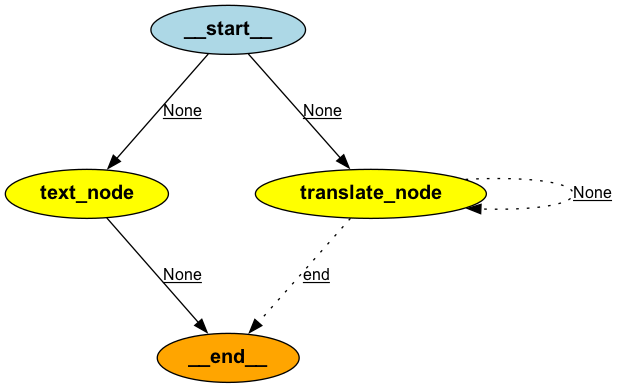

In [245]:
from IPython.display import Image, display

# Create the graph and compile the workflow
graph = create_graph()
workflow = compile_workflow(graph)
print("Graph and workflow created.")

display(Image(workflow.get_graph().draw_png()))

In [246]:
# Define workflow parameters
verbose = True
dict_inputs = {"start_chain": "start"}

# Execute the workflow and print state changes
async for event in workflow.astream_events(dict_inputs, version="v2"):
    if verbose:
        if(event['name']=='text_node'):
            print(colored(event, "cyan"))
        elif(event['name']=='translate_node'):
            print(colored(event, "yellow"))
        else:
            print(colored(event,"magenta"))
    else:
        print("\n")

{'event': 'on_chain_start', 'data': {'input': {'start_chain': 'start'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'b9a7e8a5-d6ef-4b00-a9b0-4e84a659fd4c', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'start_chain': 'start'}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '230988a2-9f9f-4366-8169-a794b0bca0f5', 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'langgraph_task_idx': 0, 'thread_ts': '1ef50cc7-7d62-6498-bffe-28036db5cc18'}, 'parent_ids': ['b9a7e8a5-d6ef-4b00-a9b0-4e84a659fd4c']}
{'event': 'on_chain_end', 'data': {'output': {'start_chain': 'start'}, 'input': {'start_chain': 'start'}}, 'run_id': '230988a2-9f9f-4366-8169-a794b0bca0f5', 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'langgraph_task_idx': 0, 'thread_ts': '1ef50cc7-7d62-6498

CancelledError: 